## This script shows the  implementataion of DeLan Metric-IK

In [16]:

# display result of assignments
#%config ZMQInteractiveShell.ast_node_interactivity = 'last_expr_or_assign'
# make NumPy display a bit nicer
#np.set_printoptions(linewidth=100, formatter={'float': lambda x: f"{x:10.4g}" if abs(x) > 1e-10 else f"{0:8.4g}"})
# make cells nice and wide
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))
%matplotlib notebook

importing libraries

In [2]:
from posixpath import join
from cvxopt import solvers
import random
import matplotlib.pyplot as plt
from numpy.lib.function_base import average
import torch
from autograd import grad
from autograd import jacobian
import autograd.numpy as np
import autograd.numpy as jnp
import scipy.optimize as optim
from scipy.optimize import minimize, Bounds,LinearConstraint
from scipy.optimize import LinearConstraint,NonlinearConstraint
from scipy.optimize import BFGS
from  autograd.numpy import cos,sin
import pdb

Loading DeLan Model and defining analytic form of Value function

In [3]:
t = 0.02
q_prev = None

device = 'cpu'
model = torch.load('models/model_750_model_epoch_20000.pth', map_location=torch.device('cpu'))  # loaded trained model #TODO
q_dim = 6  # q_dim is the dimension of joint space
q_dim_changed = int(0.5 * q_dim)

#Weight for cost function  
w_des_vel = 0.003
weight_orient = 0.2
#Desired final Orientation of end effector
roll_des= -3.141105126296926
pitch_des= 0.00046035505135551175
yaw_des = -2.355906195444897
orient_desired  = np.asarray([ roll_des , pitch_des , yaw_des ])

#value function defnation
weight = []
for key in (model.keys()):
    # print(key)
    weight.append(model[key].cpu().numpy())  # load weight and bias


def leaky_relu(z):
    return np.maximum(0.01 * z, z)


def softplus(z, beta=1):
    return (1 / beta) * np.log(1 + np.exp(z * beta))


def assemble_lower_triangular_matrix(Lo, Ld):
    Lo = Lo.squeeze(0)
    Ld = Ld.squeeze(0)

    assert (2 * Lo.shape[0] == (Ld.shape[0] ** 2 - Ld.shape[0]))
    diagonal_matrix = np.identity(len(Ld)) * np.outer(np.ones(len(Ld)), Ld)

    L = np.tril(np.ones(diagonal_matrix.shape)) - np.eye(q_dim_changed)

    # Set off diagonals

    L = np.array([[0, 0, 0], [1, 0, 0], [0, 0, 0]]) * Lo.reshape(3)[0] + np.array([[0, 0, 0], [0, 0, 0], [1, 0, 0]]) * \
        Lo.reshape(3)[1] + np.array([[0, 0, 0], [0, 0, 0], [0, 1, 0]]) * Lo.reshape(3)[2]
    # Add diagonals
    L = L + diagonal_matrix
    return L


def value(x1):
    global weight, goal
    fc1_w = weight[0]
    fc1_b = weight[1]
    fc2_w = weight[2]
    fc2_b = weight[3]
    fc_Ld_w = weight[4]
    fc_Ld_b = weight[5]
    fc_Lo_w = weight[6]
    fc_Lo_b = weight[7]
    #pdb.set_trace()
    net_input = np.concatenate([np.squeeze(x1), np.squeeze(goal)], axis=0)
    net_input = np.array([net_input])

    z1 = np.dot(net_input, fc1_w.transpose()) + fc1_b
    hidden1 = leaky_relu(z1)
    z2 = np.dot(hidden1, fc2_w.transpose()) + fc2_b
    hidden2 = leaky_relu(z2)
    hidden3 = np.dot(hidden2, fc_Ld_w.transpose()) + fc_Ld_b
    Ld = softplus(hidden3)
    Lo = np.dot(hidden2, fc_Lo_w.transpose()) + fc_Lo_b
    L = assemble_lower_triangular_matrix(Lo, Ld)

    H = L @ L.transpose() + 1e-9 * np.eye(3)
    return H

In [4]:
#Analytical funtion for forward kinematics of Franka Panda
def fk_franka_orient(q):
    
    q_1 = q[0]
    q_2 = q[1]
    q_3 = q[2]
    q_4 = q[3]
    q_5 = q[4]
    q_6 = q[5]
    q_7 = q[6]

    x = -0.107*(((np.sin(q_1)*np.sin(q_3) - np.cos(q_1)*np.cos(q_2)*np.cos(q_3))*np.cos(q_4) - np.sin(q_2)*np.sin(q_4)*np.cos(q_1))*np.cos(q_5) + (np.sin(q_1)*np.cos(q_3) + np.sin(q_3)*np.cos(q_1)*np.cos(q_2))*np.sin(q_5))*np.sin(q_6) - 0.088*(((np.sin(q_1)*np.sin(q_3) - np.cos(q_1)*np.cos(q_2)*np.cos(q_3))*np.cos(q_4) - np.sin(q_2)*np.sin(q_4)*np.cos(q_1))*np.cos(q_5) + (np.sin(q_1)*np.cos(q_3) + np.sin(q_3)*np.cos(q_1)*np.cos(q_2))*np.sin(q_5))*np.cos(q_6) + 0.088*((np.sin(q_1)*np.sin(q_3) - np.cos(q_1)*np.cos(q_2)*np.cos(q_3))*np.sin(q_4) + np.sin(q_2)*np.cos(q_1)*np.cos(q_4))*np.sin(q_6) - 0.107*((np.sin(q_1)*np.sin(q_3) - np.cos(q_1)*np.cos(q_2)*np.cos(q_3))*np.sin(q_4) + np.sin(q_2)*np.cos(q_1)*np.cos(q_4))*np.cos(q_6) + 0.384*(np.sin(q_1)*np.sin(q_3) - np.cos(q_1)*np.cos(q_2)*np.cos(q_3))*np.sin(q_4) + 0.0825*(np.sin(q_1)*np.sin(q_3) - np.cos(q_1)*np.cos(q_2)*np.cos(q_3))*np.cos(q_4) - 0.0825*np.sin(q_1)*np.sin(q_3) - 0.0825*np.sin(q_2)*np.sin(q_4)*np.cos(q_1) + 0.384*np.sin(q_2)*np.cos(q_1)*np.cos(q_4) + 0.316*np.sin(q_2)*np.cos(q_1) + 0.0825*np.cos(q_1)*np.cos(q_2)*np.cos(q_3)

    y = 0.107*(((np.sin(q_1)*np.cos(q_2)*np.cos(q_3) + np.sin(q_3)*np.cos(q_1))*np.cos(q_4) + np.sin(q_1)*np.sin(q_2)*np.sin(q_4))*np.cos(q_5) - (np.sin(q_1)*np.sin(q_3)*np.cos(q_2) - np.cos(q_1)*np.cos(q_3))*np.sin(q_5))*np.sin(q_6) + 0.088*(((np.sin(q_1)*np.cos(q_2)*np.cos(q_3) + np.sin(q_3)*np.cos(q_1))*np.cos(q_4) + np.sin(q_1)*np.sin(q_2)*np.sin(q_4))*np.cos(q_5) - (np.sin(q_1)*np.sin(q_3)*np.cos(q_2) - np.cos(q_1)*np.cos(q_3))*np.sin(q_5))*np.cos(q_6) - 0.088*((np.sin(q_1)*np.cos(q_2)*np.cos(q_3) + np.sin(q_3)*np.cos(q_1))*np.sin(q_4) - np.sin(q_1)*np.sin(q_2)*np.cos(q_4))*np.sin(q_6) + 0.107*((np.sin(q_1)*np.cos(q_2)*np.cos(q_3) + np.sin(q_3)*np.cos(q_1))*np.sin(q_4) - np.sin(q_1)*np.sin(q_2)*np.cos(q_4))*np.cos(q_6) - 0.384*(np.sin(q_1)*np.cos(q_2)*np.cos(q_3) + np.sin(q_3)*np.cos(q_1))*np.sin(q_4) - 0.0825*(np.sin(q_1)*np.cos(q_2)*np.cos(q_3) + np.sin(q_3)*np.cos(q_1))*np.cos(q_4) - 0.0825*np.sin(q_1)*np.sin(q_2)*np.sin(q_4) + 0.384*np.sin(q_1)*np.sin(q_2)*np.cos(q_4) + 0.316*np.sin(q_1)*np.sin(q_2) + 0.0825*np.sin(q_1)*np.cos(q_2)*np.cos(q_3) + 0.0825*np.sin(q_3)*np.cos(q_1)

    z = -0.107*((np.sin(q_2)*np.cos(q_3)*np.cos(q_4) - np.sin(q_4)*np.cos(q_2))*np.cos(q_5) - np.sin(q_2)*np.sin(q_3)*np.sin(q_5))*np.sin(q_6) - 0.088*((np.sin(q_2)*np.cos(q_3)*np.cos(q_4) - np.sin(q_4)*np.cos(q_2))*np.cos(q_5) - np.sin(q_2)*np.sin(q_3)*np.sin(q_5))*np.cos(q_6) + 0.088*(np.sin(q_2)*np.sin(q_4)*np.cos(q_3) + np.cos(q_2)*np.cos(q_4))*np.sin(q_6) - 0.107*(np.sin(q_2)*np.sin(q_4)*np.cos(q_3) + np.cos(q_2)*np.cos(q_4))*np.cos(q_6) + 0.384*np.sin(q_2)*np.sin(q_4)*np.cos(q_3) + 0.0825*np.sin(q_2)*np.cos(q_3)*np.cos(q_4) - 0.0825*np.sin(q_2)*np.cos(q_3) - 0.0825*np.sin(q_4)*np.cos(q_2) + 0.384*np.cos(q_2)*np.cos(q_4) + 0.316*np.cos(q_2) + 0.33

    cq1 = np.cos(q_1)
    cq2 = np.cos(q_2)
    cq3 = np.cos(q_3)
    cq4 = np.cos(q_4)
    cq5 = np.cos(q_5)
    cq6 = np.cos(q_6)
    cq7 = np.cos(q_7)

    sq1 = np.sin(q_1)
    sq2 = np.sin(q_2)
    sq3 = np.sin(q_3)
    sq4 = np.sin(q_4)
    sq5 = np.sin(q_5)
    sq6 = np.sin(q_6)
    sq7 = np.sin(q_7)
    ax1 = -0.5*(((np.sin(q_1)*np.cos(q_2)*np.cos(q_3) + np.sin(q_3)*np.cos(q_1))*np.cos(q_4) + np.sin(q_1)*np.sin(q_2)*np.sin(q_4))*np.cos(q_5) - (np.sin(q_1)*np.sin(q_3)*np.cos(q_2) - np.cos(q_1)*np.cos(q_3))*np.sin(q_5))*np.sin(q_6) + 0.5*(((np.sin(q_2)*np.cos(q_3)*np.cos(q_4) - np.sin(q_4)*np.cos(q_2))*np.cos(q_5) - np.sin(q_2)*np.sin(q_3)*np.sin(q_5))*np.cos(q_6) - (np.sin(q_2)*np.sin(q_4)*np.cos(q_3) + np.cos(q_2)*np.cos(q_4))*np.sin(q_6))*np.sin(q_7) - 0.5*((np.sin(q_1)*np.cos(q_2)*np.cos(q_3) + np.sin(q_3)*np.cos(q_1))*np.sin(q_4) - np.sin(q_1)*np.sin(q_2)*np.cos(q_4))*np.cos(q_6) - 0.5*((np.sin(q_2)*np.cos(q_3)*np.cos(q_4) - np.sin(q_4)*np.cos(q_2))*np.sin(q_5) + np.sin(q_2)*np.sin(q_3)*np.cos(q_5))*np.cos(q_7)

    ax2 = -0.5*(((np.sin(q_1)*np.sin(q_3) - np.cos(q_1)*np.cos(q_2)*np.cos(q_3))*np.cos(q_4) - np.sin(q_2)*np.sin(q_4)*np.cos(q_1))*np.cos(q_5) + (np.sin(q_1)*np.cos(q_3) + np.sin(q_3)*np.cos(q_1)*np.cos(q_2))*np.sin(q_5))*np.sin(q_6) + 0.5*(((np.sin(q_2)*np.cos(q_3)*np.cos(q_4) - np.sin(q_4)*np.cos(q_2))*np.cos(q_5) - np.sin(q_2)*np.sin(q_3)*np.sin(q_5))*np.cos(q_6) - (np.sin(q_2)*np.sin(q_4)*np.cos(q_3) + np.cos(q_2)*np.cos(q_4))*np.sin(q_6))*np.cos(q_7) - 0.5*((np.sin(q_1)*np.sin(q_3) - np.cos(q_1)*np.cos(q_2)*np.cos(q_3))*np.sin(q_4) + np.sin(q_2)*np.cos(q_1)*np.cos(q_4))*np.cos(q_6) + 0.5*((np.sin(q_2)*np.cos(q_3)*np.cos(q_4) - np.sin(q_4)*np.cos(q_2))*np.sin(q_5) + np.sin(q_2)*np.sin(q_3)*np.cos(q_5))*np.sin(q_7)

    ax3 = -0.5*np.sin(q_2)*np.sin(q_4)*np.sin(q_5)*np.cos(q_1 + q_7) + 0.5*np.sin(q_2)*np.sin(q_4)*np.sin(q_1 + q_7)*np.cos(q_5)*np.cos(q_6) + 0.5*np.sin(q_2)*np.sin(q_6)*np.sin(q_1 + q_7)*np.cos(q_4) - 0.5*np.sin(q_3)*np.sin(q_4)*np.sin(q_6)*np.cos(q_1 + q_7) - 0.5*np.sin(q_3)*np.sin(q_5)*np.sin(q_1 + q_7)*np.cos(q_2)*np.cos(q_6) + 0.5*np.sin(q_3)*np.sin(q_5)*np.sin(q_1 + q_7)*np.cos(q_4) - 0.5*np.sin(q_3)*np.cos(q_2)*np.cos(q_5)*np.cos(q_1 + q_7) + 0.5*np.sin(q_3)*np.cos(q_4)*np.cos(q_5)*np.cos(q_6)*np.cos(q_1 + q_7) - 0.5*np.sin(q_4)*np.sin(q_6)*np.sin(q_1 + q_7)*np.cos(q_2)*np.cos(q_3) - 0.5*np.sin(q_5)*np.cos(q_2)*np.cos(q_3)*np.cos(q_4)*np.cos(q_1 + q_7) + 0.5*np.sin(q_5)*np.cos(q_3)*np.cos(q_6)*np.cos(q_1 + q_7) + 0.5*np.sin(q_1 + q_7)*np.cos(q_2)*np.cos(q_3)*np.cos(q_4)*np.cos(q_5)*np.cos(q_6) - 0.5*np.sin(q_1 + q_7)*np.cos(q_3)*np.cos(q_5)

    r_32 = -cq7*(cq5*sq2*sq3 - sq5*(cq2*sq4 - cq3*cq4*sq2)) - sq7*(cq6*(cq5*(cq2*sq4 - cq3*cq4*sq2) + sq2*sq3*sq5) + sq6*(cq2*cq4 + cq3*sq2*sq4))
    r_33 = -cq6*(cq2*cq4 + cq3*sq2*sq4) + sq6*(cq5*(cq2*sq4 - cq3*cq4*sq2) + sq2*sq3*sq5)
    r_31 = cq7*(cq6*(cq5*(cq2*sq4 - cq3*cq4*sq2) + sq2*sq3*sq5) + sq6*(cq2*cq4 + cq3*sq2*sq4)) - sq7*(cq5*sq2*sq3 - sq5*(cq2*sq4 - cq3*cq4*sq2))
    r_21 = cq7*(cq6*(cq5*(cq4*(cq1*sq3 + cq2*cq3*sq1) + sq1*sq2*sq4) + sq5*(cq1*cq3 - cq2*sq1*sq3)) + sq6*(cq4*sq1*sq2 - sq4*(cq1*sq3 + cq2*cq3*sq1))) - sq7*(cq5*(cq1*cq3 - cq2*sq1*sq3) - sq5*(cq4*(cq1*sq3 + cq2*cq3*sq1) + sq1*sq2*sq4))
    r_11 = cq7*(cq6*(cq5*(cq1*sq2*sq4 + cq4*(cq1*cq2*cq3 - sq1*sq3)) - sq5*(cq1*cq2*sq3 + cq3*sq1)) + sq6*(cq1*cq4*sq2 - sq4*(cq1*cq2*cq3 - sq1*sq3))) + sq7*(cq5*(cq1*cq2*sq3 + cq3*sq1) + sq5*(cq1*sq2*sq4 + cq4*(cq1*cq2*cq3 - sq1*sq3)))
    roll_ = np.arctan2(r_32, r_33)
    pitch_=-np.arcsin(r_31)
    yaw_ = np.arctan2(r_21,r_11)
    
    cartpos = np.array([x,y,z])
    pose = [x,y,z,roll_,pitch_,yaw_]
    return pose

#function to compute joint and Cart Space Trajectory Cost 
def traj_cost(trajectory):
    #pdb.set_trace()
    cost = 0
    cart_cost = 0
    for i in range(len(trajectory) - 1):
        cost += np.linalg.norm(np.asarray(trajectory[i]) - np.asarray(trajectory[i + 1]), ord=2)
        # pdb.set_trace()
        current = np.asarray(fk_franka_orient(trajectory[i]))[0:3]  
        next = np.asarray(fk_franka_orient(trajectory[i+1]))[0:3] 
        cart_cost += np.linalg.norm(current - next, ord=2)
    return cost, cart_cost

In [5]:
#plotting the traj/ trajc_dot
#orientResidual_tracker, cart_cost_tracker , trajectory,init_joint, end_cart,qdottrajc,plotno
def plot(orientResidual_tracker, cost_tracker , TrajectoryValue,init_joint, end_cartesian,qdottraj , plotno):
    x_fin = end_cartesian.item(0)
    y_fin = end_cartesian.item(1)
    z_fin = end_cartesian.item(2)
    pos = fk_franka_orient(init_joint)[0:3]
    # pos = init_joint
    x_init = pos[0]
    y_init = pos[1]
    z_init = pos[2]
    countValue = len(TrajectoryValue)
    xopt_solValue = np.zeros(countValue - 1)
    yopt_solValue = np.zeros(countValue - 1)
    zopt_solValue = np.zeros(countValue - 1)
    for i in range(0, countValue - 1):
        pos = fk_franka_orient(TrajectoryValue[i])[0:3]
        xopt_solValue[i] = pos[0]
        yopt_solValue[i] = pos[1]
        zopt_solValue[i] = pos[2]
    JointCostValue, CartCostValue = traj_cost(TrajectoryValue)

    fig = plt.figure(1, figsize=(12, 12), dpi=100)
    plt.title("3d-Trajectory Plot in cartesian coordinate")
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(xopt_solValue, yopt_solValue, zopt_solValue, '--or', linewidth=2.0, markersize=6.0,
            label=('Traj cost in : joint-Space=', "{:.2f}".format(JointCostValue), 'cart-Space=',
                   "{:.2f}".format(CartCostValue), 'Orient_cost_residual', "{:.2f}".format(orientResidual_tracker[-1]), 'euclid_cost_residual', "{:.2f}".format(cost_tracker[-1])))
    ax.plot(x_init * np.ones(1), y_init * np.ones(1), z_init * np.ones(1), 'om', markersize=15)
    ax.plot(x_fin * np.ones(1), y_fin * np.ones(1), z_fin * np.ones(1), 'og', markersize=10)
    ax.set_xlim3d(-1.0, 1.0)
    ax.set_ylim3d(-1.0, 1.0)
    ax.set_zlim3d(-0.3, 1.2)
    ax.legend(loc='upper left', frameon=False)
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    plt.show()
    #plt.close()
    fig = plt.figure(2, figsize=(12, 8), dpi=100)
    plt.title("cart-Cost / Orientation-residual cost  VS iteration")
    plt.plot(orientResidual_tracker, label=(
        'orient residual'))
    plt.plot(cost_tracker, label=(
        'euclid-cost residual'))
    plt.legend(loc='upper left', frameon=False)
    plt.show()
    fig =plt.figure(3, figsize=(12, 8), dpi=100)
    trajct = np.asarray(TrajectoryValue)
    plt.plot(trajct[:-1, 0], '-o', linewidth=1.0, markersize=3.0 , label= ('joint1'))
    plt.plot(trajct[:-1, 1], '-o', linewidth=1.0, markersize=3.0,label= ('joint2'))
    plt.plot(trajct[:, 2], '-o', linewidth=1.0, markersize=3.0,label= ('joint3'))
    plt.plot(trajct[:, 3], '-o', linewidth=1.0, markersize=3.0,label= ('joint4'))
    plt.plot(trajct[:, 4], '-o', linewidth=1.0, markersize=3.0,label= ('joint5'))
    plt.plot(trajct[:, 5], '-o', linewidth=1.0, markersize=3.0,label= ('joint6'))
    plt.plot(trajct[:, 6], '-o', linewidth=1.0, markersize=3.0,label= ('joint7'))
    plt.title("joint angle trajc  VS iteration")
    plt.legend(loc='upper left', frameon=False)
    plt.show()
    fig =plt.figure(4, figsize=(12, 8), dpi=100)
    trajct = np.asarray(qdottrajc)
    plt.plot(trajct[:-1, 0], '-o', linewidth=1.0, markersize=3.0 , label= ('joint1'))
    plt.plot(trajct[:-1, 1], '-o', linewidth=1.0, markersize=3.0,label= ('joint2'))
    plt.plot(trajct[:, 2], '-o', linewidth=1.0, markersize=3.0,label= ('joint3'))
    plt.plot(trajct[:, 3], '-o', linewidth=1.0, markersize=3.0,label= ('joint4'))
    plt.plot(trajct[:, 4], '-o', linewidth=1.0, markersize=3.0,label= ('joint5'))
    plt.plot(trajct[:, 5], '-o', linewidth=1.0, markersize=3.0,label= ('joint6'))
    plt.plot(trajct[:, 6], '-o', linewidth=1.0, markersize=3.0,label= ('joint7'))
    plt.title("q-dot trajc VS iteration ")
    plt.legend(loc='upper left', frameon=False)
    plt.show()
    return

DeLan Metric IK formulation:

Lets say we the current joint angle is $\textbf{q}_{init}$ and the corresponding end-effector position is $x_{init}$. We want to solve for the $\dot{\textbf{q}}$ that will take us to $\textbf{x}_{next}$ at the next instant. We can formulate the following optimization problem for it at iteration $k$.

\begin{align}
\min_{\dot{\textbf{q}}}\frac{1}{2}(\textbf{x}_{next}-\textbf{x}_{fin})^T\textbf{H}(\textbf{x}_{next}, \textbf{x}_{fin})(\textbf{x}_{next}-\textbf{x}_{fin})+\Vert \dot{\textbf{q}}\Vert_2^2 + orientation_{cost} --eqn(1)\\
f_{fk}(\dot{\textbf{q}}t+\textbf{q}_{init}) = \textbf{x}_{next}---eqn(2)\\
{\textbf{q}}_{min}\leq {\textbf{q}}  \leq {\textbf{q}}_{max}\\
{\text{or we can write}}\\
-{\textbf{q}}_{max}\leq \dot{\textbf{q}}*t +\textbf{q}_{init} \leq {\textbf{q}}_{max}\\
-\dot{\textbf{q}}_{max}\leq \dot{\textbf{q}}  \leq \dot{\textbf{q}}_{max}\\
-\ddot{\textbf{q}}_{max}t \leq \dot{\textbf{q}}-\dot{\textbf{q}}^{k-1} \leq \ddot{\textbf{q}}_{max}t
\end{align}   

Simplification: The $\textbf{H}$ matrix is a function of $\textbf{x}_{next}$ itself which is not known. However, we can make one simplification, we can replace $\textbf{x}_{next}$ with $\textbf{x}_{init}$ , i.e the current position in $\textbf{H}$. This makes the first term convex and gets rid of the non-smoothness aspect. 

Scipy can solve the optimization problem. The only problem is the non-convex equality constraints from forward kinematics but we can code it as non-linear equality constraints in scipy SLSQP.

We solve the optimization in MPC setting. That is, we solve $\dot{\textbf{q}}$ and updated $\textbf{q}_{init}$ and so on.

In [6]:
# Cost function defination eqn-1

def costfxn(solverVariable,x_position,val):
  global goal,diffinCart,roll_des,pitch_des,yaw_des ,w_des_vel,weight_orient
  diff = solverVariable[7:] - goal
  cost = np.matmul(diff.transpose(),np.matmul(val, diff ))
  diffprev = x_position - goal
  cost_prev =np.matmul(diffprev.transpose(),np.matmul(val, diffprev ))

  smoothness_cost = np.sum(solverVariable[0:7]**2,axis = 0)
  global q_prev, t ,maxCartdist,iteration

  roll_des= -3.141105126296926
  pitch_des= 0.00046035505135551175
  yaw_des = -2.355906195444897
  orient_desired  = np.asarray([ roll_des , pitch_des , yaw_des ])
  q = solverVariable[:7]*t + q_prev  
  q_1 = q[0]
  q_2 = q[1]
  q_3 = q[2]
  q_4 = q[3]
  q_5 = q[4]
  q_6 = q[5]
  q_7 = q[6]

  cq1 = np.cos(q_1)
  cq2 = np.cos(q_2)
  cq3 = np.cos(q_3)
  cq4 = np.cos(q_4)
  cq5 = np.cos(q_5)
  cq6 = np.cos(q_6)
  cq7 = np.cos(q_7)

  sq1 = np.sin(q_1)
  sq2 = np.sin(q_2)
  sq3 = np.sin(q_3)
  sq4 = np.sin(q_4)
  sq5 = np.sin(q_5)
  sq6 = np.sin(q_6)
  sq7 = np.sin(q_7)
  ax1 = -0.5*(((np.sin(q_1)*np.cos(q_2)*np.cos(q_3) + np.sin(q_3)*np.cos(q_1))*np.cos(q_4) + np.sin(q_1)*np.sin(q_2)*np.sin(q_4))*np.cos(q_5) - (np.sin(q_1)*np.sin(q_3)*np.cos(q_2) - np.cos(q_1)*np.cos(q_3))*np.sin(q_5))*np.sin(q_6) + 0.5*(((np.sin(q_2)*np.cos(q_3)*np.cos(q_4) - np.sin(q_4)*np.cos(q_2))*np.cos(q_5) - np.sin(q_2)*np.sin(q_3)*np.sin(q_5))*np.cos(q_6) - (np.sin(q_2)*np.sin(q_4)*np.cos(q_3) + np.cos(q_2)*np.cos(q_4))*np.sin(q_6))*np.sin(q_7) - 0.5*((np.sin(q_1)*np.cos(q_2)*np.cos(q_3) + np.sin(q_3)*np.cos(q_1))*np.sin(q_4) - np.sin(q_1)*np.sin(q_2)*np.cos(q_4))*np.cos(q_6) - 0.5*((np.sin(q_2)*np.cos(q_3)*np.cos(q_4) - np.sin(q_4)*np.cos(q_2))*np.sin(q_5) + np.sin(q_2)*np.sin(q_3)*np.cos(q_5))*np.cos(q_7)

  ax2 = -0.5*(((np.sin(q_1)*np.sin(q_3) - np.cos(q_1)*np.cos(q_2)*np.cos(q_3))*np.cos(q_4) - np.sin(q_2)*np.sin(q_4)*np.cos(q_1))*np.cos(q_5) + (np.sin(q_1)*np.cos(q_3) + np.sin(q_3)*np.cos(q_1)*np.cos(q_2))*np.sin(q_5))*np.sin(q_6) + 0.5*(((np.sin(q_2)*np.cos(q_3)*np.cos(q_4) - np.sin(q_4)*np.cos(q_2))*np.cos(q_5) - np.sin(q_2)*np.sin(q_3)*np.sin(q_5))*np.cos(q_6) - (np.sin(q_2)*np.sin(q_4)*np.cos(q_3) + np.cos(q_2)*np.cos(q_4))*np.sin(q_6))*np.cos(q_7) - 0.5*((np.sin(q_1)*np.sin(q_3) - np.cos(q_1)*np.cos(q_2)*np.cos(q_3))*np.sin(q_4) + np.sin(q_2)*np.cos(q_1)*np.cos(q_4))*np.cos(q_6) + 0.5*((np.sin(q_2)*np.cos(q_3)*np.cos(q_4) - np.sin(q_4)*np.cos(q_2))*np.sin(q_5) + np.sin(q_2)*np.sin(q_3)*np.cos(q_5))*np.sin(q_7)

  ax3 = -0.5*np.sin(q_2)*np.sin(q_4)*np.sin(q_5)*np.cos(q_1 + q_7) + 0.5*np.sin(q_2)*np.sin(q_4)*np.sin(q_1 + q_7)*np.cos(q_5)*np.cos(q_6) + 0.5*np.sin(q_2)*np.sin(q_6)*np.sin(q_1 + q_7)*np.cos(q_4) - 0.5*np.sin(q_3)*np.sin(q_4)*np.sin(q_6)*np.cos(q_1 + q_7) - 0.5*np.sin(q_3)*np.sin(q_5)*np.sin(q_1 + q_7)*np.cos(q_2)*np.cos(q_6) + 0.5*np.sin(q_3)*np.sin(q_5)*np.sin(q_1 + q_7)*np.cos(q_4) - 0.5*np.sin(q_3)*np.cos(q_2)*np.cos(q_5)*np.cos(q_1 + q_7) + 0.5*np.sin(q_3)*np.cos(q_4)*np.cos(q_5)*np.cos(q_6)*np.cos(q_1 + q_7) - 0.5*np.sin(q_4)*np.sin(q_6)*np.sin(q_1 + q_7)*np.cos(q_2)*np.cos(q_3) - 0.5*np.sin(q_5)*np.cos(q_2)*np.cos(q_3)*np.cos(q_4)*np.cos(q_1 + q_7) + 0.5*np.sin(q_5)*np.cos(q_3)*np.cos(q_6)*np.cos(q_1 + q_7) + 0.5*np.sin(q_1 + q_7)*np.cos(q_2)*np.cos(q_3)*np.cos(q_4)*np.cos(q_5)*np.cos(q_6) - 0.5*np.sin(q_1 + q_7)*np.cos(q_3)*np.cos(q_5)

  r_32 = -cq7*(cq5*sq2*sq3 - sq5*(cq2*sq4 - cq3*cq4*sq2)) - sq7*(cq6*(cq5*(cq2*sq4 - cq3*cq4*sq2) + sq2*sq3*sq5) + sq6*(cq2*cq4 + cq3*sq2*sq4))
  r_33 = -cq6*(cq2*cq4 + cq3*sq2*sq4) + sq6*(cq5*(cq2*sq4 - cq3*cq4*sq2) + sq2*sq3*sq5)
  r_31 = cq7*(cq6*(cq5*(cq2*sq4 - cq3*cq4*sq2) + sq2*sq3*sq5) + sq6*(cq2*cq4 + cq3*sq2*sq4)) - sq7*(cq5*sq2*sq3 - sq5*(cq2*sq4 - cq3*cq4*sq2))
  r_21 = cq7*(cq6*(cq5*(cq4*(cq1*sq3 + cq2*cq3*sq1) + sq1*sq2*sq4) + sq5*(cq1*cq3 - cq2*sq1*sq3)) + sq6*(cq4*sq1*sq2 - sq4*(cq1*sq3 + cq2*cq3*sq1))) - sq7*(cq5*(cq1*cq3 - cq2*sq1*sq3) - sq5*(cq4*(cq1*sq3 + cq2*cq3*sq1) + sq1*sq2*sq4))
  r_11 = cq7*(cq6*(cq5*(cq1*sq2*sq4 + cq4*(cq1*cq2*cq3 - sq1*sq3)) - sq5*(cq1*cq2*sq3 + cq3*sq1)) + sq6*(cq1*cq4*sq2 - sq4*(cq1*cq2*cq3 - sq1*sq3))) + sq7*(cq5*(cq1*cq2*sq3 + cq3*sq1) + sq5*(cq1*sq2*sq4 + cq4*(cq1*cq2*cq3 - sq1*sq3)))
  f_orient_cost = np.linalg.norm( ((r_32/r_33)-np.tan(roll_des))**2+(-np.sin(r_31)-np.sin(pitch_des))**2  +  ((r_21 / r_11) -np.tan(yaw_des ) )**2 ) 
  totalcost = np.add(cost , w_des_vel*smoothness_cost  )  
  weight  = weight_orient/cost_prev
  if f_orient_cost< 0.08999999999999999999999 :
  	weight = 0
  totalcost = totalcost + weight*f_orient_cost
  return totalcost
jac_cost = jacobian(costfxn)   #jaccost has a shape of (3,)


#Defination of  Non linear constraint function eqn-2
def constraintfxn(qdot_x_next):
    global t, q_prev
    q = qdot_x_next[:7]*t  + q_prev
    x_next = qdot_x_next[7]
    y_next = qdot_x_next[8]
    z_next = qdot_x_next[9]

    # x,y,z= robot.fkine(q) #TODO
    q_1 = q[0]
    q_2 = q[1]
    q_3 = q[2]
    q_4 = q[3]
    q_5 = q[4]
    q_6 = q[5]
    q_7 = q[6]


    x = -0.107*(((np.sin(q_1)*np.sin(q_3) - np.cos(q_1)*np.cos(q_2)*np.cos(q_3))*np.cos(q_4) - np.sin(q_2)*np.sin(q_4)*np.cos(q_1))*np.cos(q_5) + (np.sin(q_1)*np.cos(q_3) + np.sin(q_3)*np.cos(q_1)*np.cos(q_2))*np.sin(q_5))*np.sin(q_6) - 0.088*(((np.sin(q_1)*np.sin(q_3) - np.cos(q_1)*np.cos(q_2)*np.cos(q_3))*np.cos(q_4) - np.sin(q_2)*np.sin(q_4)*np.cos(q_1))*np.cos(q_5) + (np.sin(q_1)*np.cos(q_3) + np.sin(q_3)*np.cos(q_1)*np.cos(q_2))*np.sin(q_5))*np.cos(q_6) + 0.088*((np.sin(q_1)*np.sin(q_3) - np.cos(q_1)*np.cos(q_2)*np.cos(q_3))*np.sin(q_4) + np.sin(q_2)*np.cos(q_1)*np.cos(q_4))*np.sin(q_6) - 0.107*((np.sin(q_1)*np.sin(q_3) - np.cos(q_1)*np.cos(q_2)*np.cos(q_3))*np.sin(q_4) + np.sin(q_2)*np.cos(q_1)*np.cos(q_4))*np.cos(q_6) + 0.384*(np.sin(q_1)*np.sin(q_3) - np.cos(q_1)*np.cos(q_2)*np.cos(q_3))*np.sin(q_4) + 0.0825*(np.sin(q_1)*np.sin(q_3) - np.cos(q_1)*np.cos(q_2)*np.cos(q_3))*np.cos(q_4) - 0.0825*np.sin(q_1)*np.sin(q_3) - 0.0825*np.sin(q_2)*np.sin(q_4)*np.cos(q_1) + 0.384*np.sin(q_2)*np.cos(q_1)*np.cos(q_4) + 0.316*np.sin(q_2)*np.cos(q_1) + 0.0825*np.cos(q_1)*np.cos(q_2)*np.cos(q_3)

    y = 0.107*(((np.sin(q_1)*np.cos(q_2)*np.cos(q_3) + np.sin(q_3)*np.cos(q_1))*np.cos(q_4) + np.sin(q_1)*np.sin(q_2)*np.sin(q_4))*np.cos(q_5) - (np.sin(q_1)*np.sin(q_3)*np.cos(q_2) - np.cos(q_1)*np.cos(q_3))*np.sin(q_5))*np.sin(q_6) + 0.088*(((np.sin(q_1)*np.cos(q_2)*np.cos(q_3) + np.sin(q_3)*np.cos(q_1))*np.cos(q_4) + np.sin(q_1)*np.sin(q_2)*np.sin(q_4))*np.cos(q_5) - (np.sin(q_1)*np.sin(q_3)*np.cos(q_2) - np.cos(q_1)*np.cos(q_3))*np.sin(q_5))*np.cos(q_6) - 0.088*((np.sin(q_1)*np.cos(q_2)*np.cos(q_3) + np.sin(q_3)*np.cos(q_1))*np.sin(q_4) - np.sin(q_1)*np.sin(q_2)*np.cos(q_4))*np.sin(q_6) + 0.107*((np.sin(q_1)*np.cos(q_2)*np.cos(q_3) + np.sin(q_3)*np.cos(q_1))*np.sin(q_4) - np.sin(q_1)*np.sin(q_2)*np.cos(q_4))*np.cos(q_6) - 0.384*(np.sin(q_1)*np.cos(q_2)*np.cos(q_3) + np.sin(q_3)*np.cos(q_1))*np.sin(q_4) - 0.0825*(np.sin(q_1)*np.cos(q_2)*np.cos(q_3) + np.sin(q_3)*np.cos(q_1))*np.cos(q_4) - 0.0825*np.sin(q_1)*np.sin(q_2)*np.sin(q_4) + 0.384*np.sin(q_1)*np.sin(q_2)*np.cos(q_4) + 0.316*np.sin(q_1)*np.sin(q_2) + 0.0825*np.sin(q_1)*np.cos(q_2)*np.cos(q_3) + 0.0825*np.sin(q_3)*np.cos(q_1)

    z = -0.107*((np.sin(q_2)*np.cos(q_3)*np.cos(q_4) - np.sin(q_4)*np.cos(q_2))*np.cos(q_5) - np.sin(q_2)*np.sin(q_3)*np.sin(q_5))*np.sin(q_6) - 0.088*((np.sin(q_2)*np.cos(q_3)*np.cos(q_4) - np.sin(q_4)*np.cos(q_2))*np.cos(q_5) - np.sin(q_2)*np.sin(q_3)*np.sin(q_5))*np.cos(q_6) + 0.088*(np.sin(q_2)*np.sin(q_4)*np.cos(q_3) + np.cos(q_2)*np.cos(q_4))*np.sin(q_6) - 0.107*(np.sin(q_2)*np.sin(q_4)*np.cos(q_3) + np.cos(q_2)*np.cos(q_4))*np.cos(q_6) + 0.384*np.sin(q_2)*np.sin(q_4)*np.cos(q_3) + 0.0825*np.sin(q_2)*np.cos(q_3)*np.cos(q_4) - 0.0825*np.sin(q_2)*np.cos(q_3) - 0.0825*np.sin(q_4)*np.cos(q_2) + 0.384*np.cos(q_2)*np.cos(q_4) + 0.316*np.cos(q_2) + 0.33
    pos_residual = np.array([x - x_next,y-y_next,z - z_next])
    return pos_residual

#Analytic function for jacobian of Nonlinear constraint function defined above 
def compute_franka_jac(qdot_x_next):

    global q_prev,t
    qdot = qdot_x_next[:7]
    qinit =  q_prev  
    qdot_1 = qdot[0]
    qdot_2 = qdot[1]
    qdot_3 = qdot[2]
    qdot_4 = qdot[3]
    qdot_5 = qdot[4]
    qdot_6 = qdot[5]
    qdot_7 = qdot[6]
    
    
    qinit_1 = qinit[0]
    qinit_2 = qinit[1]
    qinit_3 = qinit[2]
    qinit_4 = qinit[3]
    qinit_5 = qinit[4]
    qinit_6 = qinit[5]
    qinit_7 = qinit[6]
  
    const_1_q_1 = 0.0825*t*sin(qdot_1*t + qinit_1)*sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4) - 0.384*t*sin(qdot_1*t + qinit_1)*sin(qdot_2*t + qinit_2)*cos(qdot_4*t + qinit_4) - 0.316*t*sin(qdot_1*t + qinit_1)*sin(qdot_2*t + qinit_2) - 0.0825*t*sin(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3) - 0.0825*t*sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1) + (0.088*(-t*sin(qdot_1*t + qinit_1)*sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4) + (-t*sin(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3) - t*sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1))*cos(qdot_4*t + qinit_4))*cos(qdot_5*t + qinit_5) + 0.088*(t*sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3)*cos(qdot_2*t + qinit_2) - t*cos(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3))*sin(qdot_5*t + qinit_5))*cos(qdot_6*t + qinit_6) + (0.107*(-t*sin(qdot_1*t + qinit_1)*sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4) + (-t*sin(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3) - t*sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1))*cos(qdot_4*t + qinit_4))*cos(qdot_5*t + qinit_5) + 0.107*(t*sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3)*cos(qdot_2*t + qinit_2) - t*cos(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3))*sin(qdot_5*t + qinit_5))*sin(qdot_6*t + qinit_6) + (-0.088*t*sin(qdot_1*t + qinit_1)*sin(qdot_2*t + qinit_2)*cos(qdot_4*t + qinit_4) + 0.088*(t*sin(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3) + t*sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1))*sin(qdot_4*t + qinit_4))*sin(qdot_6*t + qinit_6) + (0.107*t*sin(qdot_1*t + qinit_1)*sin(qdot_2*t + qinit_2)*cos(qdot_4*t + qinit_4) - 0.107*(t*sin(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3) + t*sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1))*sin(qdot_4*t + qinit_4))*cos(qdot_6*t + qinit_6) + (0.0825*t*sin(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3) + 0.0825*t*sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1))*cos(qdot_4*t + qinit_4) + (0.384*t*sin(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3) + 0.384*t*sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1))*sin(qdot_4*t + qinit_4)
    const_1_q_2 = 0.384*t*sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4)*cos(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3) + 0.0825*t*sin(qdot_2*t + qinit_2)*cos(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3)*cos(qdot_4*t + qinit_4) - 0.0825*t*sin(qdot_2*t + qinit_2)*cos(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3) - 0.0825*t*sin(qdot_4*t + qinit_4)*cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2) + 0.384*t*cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_4*t + qinit_4) + 0.316*t*cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2) + (0.088*t*sin(qdot_2*t + qinit_2)*sin(qdot_3*t + qinit_3)*sin(qdot_5*t + qinit_5)*cos(qdot_1*t + qinit_1) + 0.088*(-t*sin(qdot_2*t + qinit_2)*cos(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3)*cos(qdot_4*t + qinit_4) + t*sin(qdot_4*t + qinit_4)*cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2))*cos(qdot_5*t + qinit_5))*cos(qdot_6*t + qinit_6) + (0.107*t*sin(qdot_2*t + qinit_2)*sin(qdot_3*t + qinit_3)*sin(qdot_5*t + qinit_5)*cos(qdot_1*t + qinit_1) + 0.107*(-t*sin(qdot_2*t + qinit_2)*cos(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3)*cos(qdot_4*t + qinit_4) + t*sin(qdot_4*t + qinit_4)*cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2))*cos(qdot_5*t + qinit_5))*sin(qdot_6*t + qinit_6) + (-0.107*t*sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4)*cos(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3) - 0.107*t*cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_4*t + qinit_4))*cos(qdot_6*t + qinit_6) + (0.088*t*sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4)*cos(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3) + 0.088*t*cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_4*t + qinit_4))*sin(qdot_6*t + qinit_6)
    const_1_q_3 = -0.0825*t*sin(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3) - 0.0825*t*sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2) + (0.088*(t*sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3) - t*cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3))*sin(qdot_5*t + qinit_5) + 0.088*(-t*sin(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3) - t*sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2))*cos(qdot_4*t + qinit_4)*cos(qdot_5*t + qinit_5))*cos(qdot_6*t + qinit_6) + (0.107*(t*sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3) - t*cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3))*sin(qdot_5*t + qinit_5) + 0.107*(-t*sin(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3) - t*sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2))*cos(qdot_4*t + qinit_4)*cos(qdot_5*t + qinit_5))*sin(qdot_6*t + qinit_6) + (0.0825*t*sin(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3) + 0.0825*t*sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2))*cos(qdot_4*t + qinit_4) + (0.384*t*sin(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3) + 0.384*t*sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2))*sin(qdot_4*t + qinit_4) + 0.088*(t*sin(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3) + t*sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2))*sin(qdot_4*t + qinit_4)*sin(qdot_6*t + qinit_6) - 0.107*(t*sin(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3) + t*sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2))*sin(qdot_4*t + qinit_4)*cos(qdot_6*t + qinit_6)
    const_1_q_4 = -t*(0.0825*sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3) - 0.0825*cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3))*sin(qdot_4*t + qinit_4) + t*(0.384*sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3) - 0.384*cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3))*cos(qdot_4*t + qinit_4) - 0.384*t*sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4)*cos(qdot_1*t + qinit_1) - 0.0825*t*sin(qdot_2*t + qinit_2)*cos(qdot_1*t + qinit_1)*cos(qdot_4*t + qinit_4) + 0.107*(-t*(-sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3) + cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3))*sin(qdot_4*t + qinit_4) + t*sin(qdot_2*t + qinit_2)*cos(qdot_1*t + qinit_1)*cos(qdot_4*t + qinit_4))*sin(qdot_6*t + qinit_6)*cos(qdot_5*t + qinit_5) + 0.088*(-t*(-sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3) + cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3))*sin(qdot_4*t + qinit_4) + t*sin(qdot_2*t + qinit_2)*cos(qdot_1*t + qinit_1)*cos(qdot_4*t + qinit_4))*cos(qdot_5*t + qinit_5)*cos(qdot_6*t + qinit_6) + (-0.107*t*(sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3) - cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3))*cos(qdot_4*t + qinit_4) + 0.107*t*sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4)*cos(qdot_1*t + qinit_1))*cos(qdot_6*t + qinit_6) + (0.088*t*(sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3) - cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3))*cos(qdot_4*t + qinit_4) - 0.088*t*sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4)*cos(qdot_1*t + qinit_1))*sin(qdot_6*t + qinit_6)
    const_1_q_5 = (-0.107*t*((-sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3) + cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3))*cos(qdot_4*t + qinit_4) + sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4)*cos(qdot_1*t + qinit_1))*sin(qdot_5*t + qinit_5) + 0.107*t*(-sin(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3) - sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2))*cos(qdot_5*t + qinit_5))*sin(qdot_6*t + qinit_6) + (-0.088*t*((-sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3) + cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3))*cos(qdot_4*t + qinit_4) + sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4)*cos(qdot_1*t + qinit_1))*sin(qdot_5*t + qinit_5) + 0.088*t*(-sin(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3) - sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2))*cos(qdot_5*t + qinit_5))*cos(qdot_6*t + qinit_6)
    const_1_q_6 = -t*(0.088*((-sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3) + cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3))*cos(qdot_4*t + qinit_4) + sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4)*cos(qdot_1*t + qinit_1))*cos(qdot_5*t + qinit_5) - 0.088*(sin(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3) + sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2))*sin(qdot_5*t + qinit_5))*sin(qdot_6*t + qinit_6) + t*(0.107*((-sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3) + cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3))*cos(qdot_4*t + qinit_4) + sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4)*cos(qdot_1*t + qinit_1))*cos(qdot_5*t + qinit_5) - 0.107*(sin(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3) + sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2))*sin(qdot_5*t + qinit_5))*cos(qdot_6*t + qinit_6) + t*(-0.088*(-sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3) + cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3))*sin(qdot_4*t + qinit_4) + 0.088*sin(qdot_2*t + qinit_2)*cos(qdot_1*t + qinit_1)*cos(qdot_4*t + qinit_4))*cos(qdot_6*t + qinit_6) - t*(0.107*(-sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3) + cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3))*sin(qdot_4*t + qinit_4) - 0.107*sin(qdot_2*t + qinit_2)*cos(qdot_1*t + qinit_1)*cos(qdot_4*t + qinit_4))*sin(qdot_6*t + qinit_6)
    const_1_q_7 = 0
    const_2_q_1 = -0.0825*t*sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3) - 0.0825*t*sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4)*cos(qdot_1*t + qinit_1) + 0.384*t*sin(qdot_2*t + qinit_2)*cos(qdot_1*t + qinit_1)*cos(qdot_4*t + qinit_4) + 0.316*t*sin(qdot_2*t + qinit_2)*cos(qdot_1*t + qinit_1) + 0.0825*t*cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3) + (0.088*(-t*sin(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3) - t*sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2))*sin(qdot_5*t + qinit_5) + 0.088*(t*sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4)*cos(qdot_1*t + qinit_1) + (-t*sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3) + t*cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3))*cos(qdot_4*t + qinit_4))*cos(qdot_5*t + qinit_5))*cos(qdot_6*t + qinit_6) + (0.107*(-t*sin(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3) - t*sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2))*sin(qdot_5*t + qinit_5) + 0.107*(t*sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4)*cos(qdot_1*t + qinit_1) + (-t*sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3) + t*cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3))*cos(qdot_4*t + qinit_4))*cos(qdot_5*t + qinit_5))*sin(qdot_6*t + qinit_6) + (0.0825*t*sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3) - 0.0825*t*cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3))*cos(qdot_4*t + qinit_4) + (0.384*t*sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3) - 0.384*t*cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3))*sin(qdot_4*t + qinit_4) + (-0.107*t*sin(qdot_2*t + qinit_2)*cos(qdot_1*t + qinit_1)*cos(qdot_4*t + qinit_4) - 0.107*(t*sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3) - t*cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3))*sin(qdot_4*t + qinit_4))*cos(qdot_6*t + qinit_6) + (0.088*t*sin(qdot_2*t + qinit_2)*cos(qdot_1*t + qinit_1)*cos(qdot_4*t + qinit_4) + 0.088*(t*sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3) - t*cos(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3))*sin(qdot_4*t + qinit_4))*sin(qdot_6*t + qinit_6)
    const_2_q_2 = 0.384*t*sin(qdot_1*t + qinit_1)*sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4)*cos(qdot_3*t + qinit_3) + 0.0825*t*sin(qdot_1*t + qinit_1)*sin(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3)*cos(qdot_4*t + qinit_4) - 0.0825*t*sin(qdot_1*t + qinit_1)*sin(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3) - 0.0825*t*sin(qdot_1*t + qinit_1)*sin(qdot_4*t + qinit_4)*cos(qdot_2*t + qinit_2) + 0.384*t*sin(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_4*t + qinit_4) + 0.316*t*sin(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2) + (0.088*t*sin(qdot_1*t + qinit_1)*sin(qdot_2*t + qinit_2)*sin(qdot_3*t + qinit_3)*sin(qdot_5*t + qinit_5) + 0.088*(-t*sin(qdot_1*t + qinit_1)*sin(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3)*cos(qdot_4*t + qinit_4) + t*sin(qdot_1*t + qinit_1)*sin(qdot_4*t + qinit_4)*cos(qdot_2*t + qinit_2))*cos(qdot_5*t + qinit_5))*cos(qdot_6*t + qinit_6) + (0.107*t*sin(qdot_1*t + qinit_1)*sin(qdot_2*t + qinit_2)*sin(qdot_3*t + qinit_3)*sin(qdot_5*t + qinit_5) + 0.107*(-t*sin(qdot_1*t + qinit_1)*sin(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3)*cos(qdot_4*t + qinit_4) + t*sin(qdot_1*t + qinit_1)*sin(qdot_4*t + qinit_4)*cos(qdot_2*t + qinit_2))*cos(qdot_5*t + qinit_5))*sin(qdot_6*t + qinit_6) + (-0.107*t*sin(qdot_1*t + qinit_1)*sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4)*cos(qdot_3*t + qinit_3) - 0.107*t*sin(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_4*t + qinit_4))*cos(qdot_6*t + qinit_6) + (0.088*t*sin(qdot_1*t + qinit_1)*sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4)*cos(qdot_3*t + qinit_3) + 0.088*t*sin(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_4*t + qinit_4))*sin(qdot_6*t + qinit_6)
    const_2_q_3 = -0.0825*t*sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3)*cos(qdot_2*t + qinit_2) + 0.0825*t*cos(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3) + (0.088*(-t*sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3)*cos(qdot_2*t + qinit_2) + t*cos(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3))*cos(qdot_4*t + qinit_4)*cos(qdot_5*t + qinit_5) + 0.088*(-t*sin(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3) - t*sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1))*sin(qdot_5*t + qinit_5))*cos(qdot_6*t + qinit_6) + (0.107*(-t*sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3)*cos(qdot_2*t + qinit_2) + t*cos(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3))*cos(qdot_4*t + qinit_4)*cos(qdot_5*t + qinit_5) + 0.107*(-t*sin(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3) - t*sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1))*sin(qdot_5*t + qinit_5))*sin(qdot_6*t + qinit_6) + (0.0825*t*sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3)*cos(qdot_2*t + qinit_2) - 0.0825*t*cos(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3))*cos(qdot_4*t + qinit_4) + (0.384*t*sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3)*cos(qdot_2*t + qinit_2) - 0.384*t*cos(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3))*sin(qdot_4*t + qinit_4) + 0.088*(t*sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3)*cos(qdot_2*t + qinit_2) - t*cos(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3))*sin(qdot_4*t + qinit_4)*sin(qdot_6*t + qinit_6) - 0.107*(t*sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3)*cos(qdot_2*t + qinit_2) - t*cos(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3))*sin(qdot_4*t + qinit_4)*cos(qdot_6*t + qinit_6)
    const_2_q_4 = t*(-0.384*sin(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3) - 0.384*sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1))*cos(qdot_4*t + qinit_4) - t*(-0.0825*sin(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3) - 0.0825*sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1))*sin(qdot_4*t + qinit_4) - 0.384*t*sin(qdot_1*t + qinit_1)*sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4) - 0.0825*t*sin(qdot_1*t + qinit_1)*sin(qdot_2*t + qinit_2)*cos(qdot_4*t + qinit_4) + (-0.107*t*(-sin(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3) - sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1))*cos(qdot_4*t + qinit_4) + 0.107*t*sin(qdot_1*t + qinit_1)*sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4))*cos(qdot_6*t + qinit_6) + (0.088*t*(-sin(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3) - sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1))*cos(qdot_4*t + qinit_4) - 0.088*t*sin(qdot_1*t + qinit_1)*sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4))*sin(qdot_6*t + qinit_6) + 0.107*(-t*(sin(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3) + sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1))*sin(qdot_4*t + qinit_4) + t*sin(qdot_1*t + qinit_1)*sin(qdot_2*t + qinit_2)*cos(qdot_4*t + qinit_4))*sin(qdot_6*t + qinit_6)*cos(qdot_5*t + qinit_5) + 0.088*(-t*(sin(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3) + sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1))*sin(qdot_4*t + qinit_4) + t*sin(qdot_1*t + qinit_1)*sin(qdot_2*t + qinit_2)*cos(qdot_4*t + qinit_4))*cos(qdot_5*t + qinit_5)*cos(qdot_6*t + qinit_6)
    const_2_q_5 = (-0.107*t*((sin(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3) + sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1))*cos(qdot_4*t + qinit_4) + sin(qdot_1*t + qinit_1)*sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4))*sin(qdot_5*t + qinit_5) + 0.107*t*(-sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3)*cos(qdot_2*t + qinit_2) + cos(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3))*cos(qdot_5*t + qinit_5))*sin(qdot_6*t + qinit_6) + (-0.088*t*((sin(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3) + sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1))*cos(qdot_4*t + qinit_4) + sin(qdot_1*t + qinit_1)*sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4))*sin(qdot_5*t + qinit_5) + 0.088*t*(-sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3)*cos(qdot_2*t + qinit_2) + cos(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3))*cos(qdot_5*t + qinit_5))*cos(qdot_6*t + qinit_6)
    const_2_q_6 = -t*(0.088*((sin(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3) + sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1))*cos(qdot_4*t + qinit_4) + sin(qdot_1*t + qinit_1)*sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4))*cos(qdot_5*t + qinit_5) - 0.088*(sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3)*cos(qdot_2*t + qinit_2) - cos(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3))*sin(qdot_5*t + qinit_5))*sin(qdot_6*t + qinit_6) + t*(0.107*((sin(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3) + sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1))*cos(qdot_4*t + qinit_4) + sin(qdot_1*t + qinit_1)*sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4))*cos(qdot_5*t + qinit_5) - 0.107*(sin(qdot_1*t + qinit_1)*sin(qdot_3*t + qinit_3)*cos(qdot_2*t + qinit_2) - cos(qdot_1*t + qinit_1)*cos(qdot_3*t + qinit_3))*sin(qdot_5*t + qinit_5))*cos(qdot_6*t + qinit_6) + t*(-0.088*(sin(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3) + sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1))*sin(qdot_4*t + qinit_4) + 0.088*sin(qdot_1*t + qinit_1)*sin(qdot_2*t + qinit_2)*cos(qdot_4*t + qinit_4))*cos(qdot_6*t + qinit_6) - t*(0.107*(sin(qdot_1*t + qinit_1)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3) + sin(qdot_3*t + qinit_3)*cos(qdot_1*t + qinit_1))*sin(qdot_4*t + qinit_4) - 0.107*sin(qdot_1*t + qinit_1)*sin(qdot_2*t + qinit_2)*cos(qdot_4*t + qinit_4))*sin(qdot_6*t + qinit_6)
    const_2_q_7 = 0
    const_3_q_1 = 0
    const_3_q_2 = 0.0825*t*sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4) - 0.384*t*sin(qdot_2*t + qinit_2)*cos(qdot_4*t + qinit_4) - 0.316*t*sin(qdot_2*t + qinit_2) + 0.384*t*sin(qdot_4*t + qinit_4)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3) + 0.0825*t*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3)*cos(qdot_4*t + qinit_4) - 0.0825*t*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3) + (-0.088*t*sin(qdot_2*t + qinit_2)*cos(qdot_4*t + qinit_4) + 0.088*t*sin(qdot_4*t + qinit_4)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3))*sin(qdot_6*t + qinit_6) + (0.107*t*sin(qdot_2*t + qinit_2)*cos(qdot_4*t + qinit_4) - 0.107*t*sin(qdot_4*t + qinit_4)*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3))*cos(qdot_6*t + qinit_6) + (0.088*t*sin(qdot_3*t + qinit_3)*sin(qdot_5*t + qinit_5)*cos(qdot_2*t + qinit_2) + 0.088*(-t*sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4) - t*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3)*cos(qdot_4*t + qinit_4))*cos(qdot_5*t + qinit_5))*cos(qdot_6*t + qinit_6) + (0.107*t*sin(qdot_3*t + qinit_3)*sin(qdot_5*t + qinit_5)*cos(qdot_2*t + qinit_2) + 0.107*(-t*sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4) - t*cos(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3)*cos(qdot_4*t + qinit_4))*cos(qdot_5*t + qinit_5))*sin(qdot_6*t + qinit_6)
    const_3_q_3 = -0.088*t*sin(qdot_2*t + qinit_2)*sin(qdot_3*t + qinit_3)*sin(qdot_4*t + qinit_4)*sin(qdot_6*t + qinit_6) + 0.107*t*sin(qdot_2*t + qinit_2)*sin(qdot_3*t + qinit_3)*sin(qdot_4*t + qinit_4)*cos(qdot_6*t + qinit_6) - 0.384*t*sin(qdot_2*t + qinit_2)*sin(qdot_3*t + qinit_3)*sin(qdot_4*t + qinit_4) - 0.0825*t*sin(qdot_2*t + qinit_2)*sin(qdot_3*t + qinit_3)*cos(qdot_4*t + qinit_4) + 0.0825*t*sin(qdot_2*t + qinit_2)*sin(qdot_3*t + qinit_3) + (0.088*t*sin(qdot_2*t + qinit_2)*sin(qdot_3*t + qinit_3)*cos(qdot_4*t + qinit_4)*cos(qdot_5*t + qinit_5) + 0.088*t*sin(qdot_2*t + qinit_2)*sin(qdot_5*t + qinit_5)*cos(qdot_3*t + qinit_3))*cos(qdot_6*t + qinit_6) + (0.107*t*sin(qdot_2*t + qinit_2)*sin(qdot_3*t + qinit_3)*cos(qdot_4*t + qinit_4)*cos(qdot_5*t + qinit_5) + 0.107*t*sin(qdot_2*t + qinit_2)*sin(qdot_5*t + qinit_5)*cos(qdot_3*t + qinit_3))*sin(qdot_6*t + qinit_6)
    const_3_q_4 = -0.0825*t*sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4)*cos(qdot_3*t + qinit_3) + 0.384*t*sin(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3)*cos(qdot_4*t + qinit_4) - 0.384*t*sin(qdot_4*t + qinit_4)*cos(qdot_2*t + qinit_2) - 0.0825*t*cos(qdot_2*t + qinit_2)*cos(qdot_4*t + qinit_4) + 0.107*(t*sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4)*cos(qdot_3*t + qinit_3) + t*cos(qdot_2*t + qinit_2)*cos(qdot_4*t + qinit_4))*sin(qdot_6*t + qinit_6)*cos(qdot_5*t + qinit_5) + 0.088*(t*sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4)*cos(qdot_3*t + qinit_3) + t*cos(qdot_2*t + qinit_2)*cos(qdot_4*t + qinit_4))*cos(qdot_5*t + qinit_5)*cos(qdot_6*t + qinit_6) + (-0.107*t*sin(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3)*cos(qdot_4*t + qinit_4) + 0.107*t*sin(qdot_4*t + qinit_4)*cos(qdot_2*t + qinit_2))*cos(qdot_6*t + qinit_6) + (0.088*t*sin(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3)*cos(qdot_4*t + qinit_4) - 0.088*t*sin(qdot_4*t + qinit_4)*cos(qdot_2*t + qinit_2))*sin(qdot_6*t + qinit_6)
    const_3_q_5 = (-0.107*t*(-sin(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3)*cos(qdot_4*t + qinit_4) + sin(qdot_4*t + qinit_4)*cos(qdot_2*t + qinit_2))*sin(qdot_5*t + qinit_5) + 0.107*t*sin(qdot_2*t + qinit_2)*sin(qdot_3*t + qinit_3)*cos(qdot_5*t + qinit_5))*sin(qdot_6*t + qinit_6) + (-0.088*t*(-sin(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3)*cos(qdot_4*t + qinit_4) + sin(qdot_4*t + qinit_4)*cos(qdot_2*t + qinit_2))*sin(qdot_5*t + qinit_5) + 0.088*t*sin(qdot_2*t + qinit_2)*sin(qdot_3*t + qinit_3)*cos(qdot_5*t + qinit_5))*cos(qdot_6*t + qinit_6)
    const_3_q_6 = -t*(0.088*(-sin(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3)*cos(qdot_4*t + qinit_4) + sin(qdot_4*t + qinit_4)*cos(qdot_2*t + qinit_2))*cos(qdot_5*t + qinit_5) + 0.088*sin(qdot_2*t + qinit_2)*sin(qdot_3*t + qinit_3)*sin(qdot_5*t + qinit_5))*sin(qdot_6*t + qinit_6) + t*(0.107*(-sin(qdot_2*t + qinit_2)*cos(qdot_3*t + qinit_3)*cos(qdot_4*t + qinit_4) + sin(qdot_4*t + qinit_4)*cos(qdot_2*t + qinit_2))*cos(qdot_5*t + qinit_5) + 0.107*sin(qdot_2*t + qinit_2)*sin(qdot_3*t + qinit_3)*sin(qdot_5*t + qinit_5))*cos(qdot_6*t + qinit_6) - t*(-0.107*sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4)*cos(qdot_3*t + qinit_3) - 0.107*cos(qdot_2*t + qinit_2)*cos(qdot_4*t + qinit_4))*sin(qdot_6*t + qinit_6) + t*(0.088*sin(qdot_2*t + qinit_2)*sin(qdot_4*t + qinit_4)*cos(qdot_3*t + qinit_3) + 0.088*cos(qdot_2*t + qinit_2)*cos(qdot_4*t + qinit_4))*cos(qdot_6*t + qinit_6)
    const_3_q_7 = 0
    const_1_x = -1
    const_2_x = 0
    const_3_x = 0
    const_1_y = 0
    const_2_y = -1
    const_3_y = 0
    const_1_z = 0
    const_2_z = 0
    const_3_z = -1
    const_1_jac = np.hstack(( const_1_q_1, const_1_q_2, const_1_q_3, const_1_q_4, const_1_q_5, const_1_q_6, const_1_q_7, const_1_x, const_1_y, const_1_z  ))
    const_2_jac = np.hstack(( const_2_q_1, const_2_q_2, const_2_q_3, const_2_q_4, const_2_q_5, const_2_q_6, const_2_q_7, const_2_x, const_2_y, const_2_z  ))
    const_3_jac = np.hstack(( const_3_q_1, const_3_q_2, const_3_q_3, const_3_q_4, const_3_q_5, const_3_q_6, const_3_q_7, const_3_x, const_3_y, const_3_z  ))
    # const_3_jac = np.hstack(( const_3_q_1, const_3_q_2, const_3_q_3, const_3_q_4, const_3_q_5, const_3_q_6, const_3_q_7, const_2_x, const_2_y, const_2_z  )) orignal MISTAKE?
    const_jac = np.vstack(( const_1_jac, const_2_jac, const_3_jac  ))    
    return const_jac

jac_constraintSympy = compute_franka_jac




In [7]:
def orient_Residual(q):
  global roll_des,pitch_des, yaw_des
  q_1 = q[0]
  q_2 = q[1]
  q_3 = q[2]
  q_4 = q[3]
  q_5 = q[4]
  q_6 = q[5]
  q_7 = q[6]

  cq1 = np.cos(q_1)
  cq2 = np.cos(q_2)
  cq3 = np.cos(q_3)
  cq4 = np.cos(q_4)
  cq5 = np.cos(q_5)
  cq6 = np.cos(q_6)
  cq7 = np.cos(q_7)

  sq1 = np.sin(q_1)
  sq2 = np.sin(q_2)
  sq3 = np.sin(q_3)
  sq4 = np.sin(q_4)
  sq5 = np.sin(q_5)
  sq6 = np.sin(q_6)
  sq7 = np.sin(q_7)
  ax1 = -0.5*(((np.sin(q_1)*np.cos(q_2)*np.cos(q_3) + np.sin(q_3)*np.cos(q_1))*np.cos(q_4) + np.sin(q_1)*np.sin(q_2)*np.sin(q_4))*np.cos(q_5) - (np.sin(q_1)*np.sin(q_3)*np.cos(q_2) - np.cos(q_1)*np.cos(q_3))*np.sin(q_5))*np.sin(q_6) + 0.5*(((np.sin(q_2)*np.cos(q_3)*np.cos(q_4) - np.sin(q_4)*np.cos(q_2))*np.cos(q_5) - np.sin(q_2)*np.sin(q_3)*np.sin(q_5))*np.cos(q_6) - (np.sin(q_2)*np.sin(q_4)*np.cos(q_3) + np.cos(q_2)*np.cos(q_4))*np.sin(q_6))*np.sin(q_7) - 0.5*((np.sin(q_1)*np.cos(q_2)*np.cos(q_3) + np.sin(q_3)*np.cos(q_1))*np.sin(q_4) - np.sin(q_1)*np.sin(q_2)*np.cos(q_4))*np.cos(q_6) - 0.5*((np.sin(q_2)*np.cos(q_3)*np.cos(q_4) - np.sin(q_4)*np.cos(q_2))*np.sin(q_5) + np.sin(q_2)*np.sin(q_3)*np.cos(q_5))*np.cos(q_7)

  ax2 = -0.5*(((np.sin(q_1)*np.sin(q_3) - np.cos(q_1)*np.cos(q_2)*np.cos(q_3))*np.cos(q_4) - np.sin(q_2)*np.sin(q_4)*np.cos(q_1))*np.cos(q_5) + (np.sin(q_1)*np.cos(q_3) + np.sin(q_3)*np.cos(q_1)*np.cos(q_2))*np.sin(q_5))*np.sin(q_6) + 0.5*(((np.sin(q_2)*np.cos(q_3)*np.cos(q_4) - np.sin(q_4)*np.cos(q_2))*np.cos(q_5) - np.sin(q_2)*np.sin(q_3)*np.sin(q_5))*np.cos(q_6) - (np.sin(q_2)*np.sin(q_4)*np.cos(q_3) + np.cos(q_2)*np.cos(q_4))*np.sin(q_6))*np.cos(q_7) - 0.5*((np.sin(q_1)*np.sin(q_3) - np.cos(q_1)*np.cos(q_2)*np.cos(q_3))*np.sin(q_4) + np.sin(q_2)*np.cos(q_1)*np.cos(q_4))*np.cos(q_6) + 0.5*((np.sin(q_2)*np.cos(q_3)*np.cos(q_4) - np.sin(q_4)*np.cos(q_2))*np.sin(q_5) + np.sin(q_2)*np.sin(q_3)*np.cos(q_5))*np.sin(q_7)

  ax3 = -0.5*np.sin(q_2)*np.sin(q_4)*np.sin(q_5)*np.cos(q_1 + q_7) + 0.5*np.sin(q_2)*np.sin(q_4)*np.sin(q_1 + q_7)*np.cos(q_5)*np.cos(q_6) + 0.5*np.sin(q_2)*np.sin(q_6)*np.sin(q_1 + q_7)*np.cos(q_4) - 0.5*np.sin(q_3)*np.sin(q_4)*np.sin(q_6)*np.cos(q_1 + q_7) - 0.5*np.sin(q_3)*np.sin(q_5)*np.sin(q_1 + q_7)*np.cos(q_2)*np.cos(q_6) + 0.5*np.sin(q_3)*np.sin(q_5)*np.sin(q_1 + q_7)*np.cos(q_4) - 0.5*np.sin(q_3)*np.cos(q_2)*np.cos(q_5)*np.cos(q_1 + q_7) + 0.5*np.sin(q_3)*np.cos(q_4)*np.cos(q_5)*np.cos(q_6)*np.cos(q_1 + q_7) - 0.5*np.sin(q_4)*np.sin(q_6)*np.sin(q_1 + q_7)*np.cos(q_2)*np.cos(q_3) - 0.5*np.sin(q_5)*np.cos(q_2)*np.cos(q_3)*np.cos(q_4)*np.cos(q_1 + q_7) + 0.5*np.sin(q_5)*np.cos(q_3)*np.cos(q_6)*np.cos(q_1 + q_7) + 0.5*np.sin(q_1 + q_7)*np.cos(q_2)*np.cos(q_3)*np.cos(q_4)*np.cos(q_5)*np.cos(q_6) - 0.5*np.sin(q_1 + q_7)*np.cos(q_3)*np.cos(q_5)

  r_32 = -cq7*(cq5*sq2*sq3 - sq5*(cq2*sq4 - cq3*cq4*sq2)) - sq7*(cq6*(cq5*(cq2*sq4 - cq3*cq4*sq2) + sq2*sq3*sq5) + sq6*(cq2*cq4 + cq3*sq2*sq4))
  r_33 = -cq6*(cq2*cq4 + cq3*sq2*sq4) + sq6*(cq5*(cq2*sq4 - cq3*cq4*sq2) + sq2*sq3*sq5)
  r_31 = cq7*(cq6*(cq5*(cq2*sq4 - cq3*cq4*sq2) + sq2*sq3*sq5) + sq6*(cq2*cq4 + cq3*sq2*sq4)) - sq7*(cq5*sq2*sq3 - sq5*(cq2*sq4 - cq3*cq4*sq2))
  r_21 = cq7*(cq6*(cq5*(cq4*(cq1*sq3 + cq2*cq3*sq1) + sq1*sq2*sq4) + sq5*(cq1*cq3 - cq2*sq1*sq3)) + sq6*(cq4*sq1*sq2 - sq4*(cq1*sq3 + cq2*cq3*sq1))) - sq7*(cq5*(cq1*cq3 - cq2*sq1*sq3) - sq5*(cq4*(cq1*sq3 + cq2*cq3*sq1) + sq1*sq2*sq4))
  r_11 = cq7*(cq6*(cq5*(cq1*sq2*sq4 + cq4*(cq1*cq2*cq3 - sq1*sq3)) - sq5*(cq1*cq2*sq3 + cq3*sq1)) + sq6*(cq1*cq4*sq2 - sq4*(cq1*cq2*cq3 - sq1*sq3))) + sq7*(cq5*(cq1*cq2*sq3 + cq3*sq1) + sq5*(cq1*sq2*sq4 + cq4*(cq1*cq2*cq3 - sq1*sq3)))
  #pdb.set_trace()
  f_orient_cost =  ((r_32/r_33)-np.tan(roll_des))**2+(-np.sin(r_31)-np.sin(pitch_des))**2  +  ((r_21 / r_11) -np.tan(yaw_des ) )**2
  return  f_orient_cost

In [8]:
#if you want to go from A to B  pass the joint position of A  fk(q_a) , x_fin
#main function to compute Delan Metric-Based IK
import time
def trajMetricBased(init_joint,end_cartesian,seq):
    start_cart = np.asarray(fk_franka_orient(init_joint))[0:3]
    global t,q_prev,goal
    print("Start : ",start_cart)
    print("Goal : ", end_cartesian)
    goal = np.squeeze(end_cartesian)
    x_des  = end_cartesian
    num_dof = 7 #franka panda
    qdot = np.zeros(num_dof)  ########## initial velocity
    qdotprev = np.zeros(num_dof)
    q_min = np.array([-165, -100, -165, -165, -165, -1.0, -165]) * np.pi / 180 # TODO
    #q_min = q_min.reshape(7,1)
    q_max = np.array([165, 101, 165, 1.0, 165, 214, 165]) * np.pi / 180  #TODO
    #q_max = q_max.reshape(7,1)


    qdot_max = np.array([2.1750	,2.1750	,2.1750	,2.1750,	2.6100,	2.6100,	2.6100])  #TODO
    qdot_min = -1*qdot_max
    qacc_max = np.array([15,	7.5,	10	,12.5	,15	,20,	20])  #TODO
    qacc_min = -1*qacc_max

    x_pos = np.asarray(fk_franka_orient(init_joint))[0:3]  ########### initial positions

    q = init_joint
    q_prev = init_joint
      ######### delta t for which the computed velocity is commanded to the robot 3msec
    x_next = fk_franka_orient(qdot*t + q)[0:3]

    mpc_iter =300
    q_1 = []
    q_2 = []
    q_3 = []
    q_4 = []
    q_5 = []
    q_6 = []
    q_7 = []
    cost_tracker = []
    trajectory = []
    qdottrajc =[]
    orientResidual =[]
    #pdb.set_trace()
    solverVariable = np.hstack((qdot,x_next))
    x_min = -np.ones(3,)*np.Inf 
    x_max = np.ones(3,)*np.Inf 
    solver_minbounds= np.hstack((qdot_min , x_min))
    solver_maxbounds = np.hstack((qdot_max , x_max))
    Amat = np.hstack((np.identity(7),np.zeros((7,3)))) 
    Bmat = np.hstack((np.identity(7),np.zeros((7,3))))
    Total_time = 0
    pose = fk_franka_orient(q)
    for i in range(0, mpc_iter):
        print(f"mpc-itr={i}")
        orientResidual.append( orient_Residual(q))
        cost_tracker.append(np.linalg.norm(x_pos - x_des))
        print("itr=",i, "euclid-norm",np.linalg.norm(x_pos - x_des) , "orient-norm" ,  orient_Residual(q)  )
        if np.linalg.norm(x_pos - x_des) < 0.05  and   orient_Residual(q)   < 0.1 :
            break
        bnds = Bounds(solver_minbounds,solver_maxbounds)
        nonlinear_constraint = NonlinearConstraint(constraintfxn , np.zeros((3,)), np.zeros((3,)) , jac= jac_constraintSympy, hess=BFGS() )
        linear_constraint_A = LinearConstraint(Amat*t, q_min-q_prev, q_max-q_prev)
        linear_constraint_B = LinearConstraint(Bmat ,qacc_min*t + qdotprev, qacc_max*t + qdotprev )
        defaultopts={ 'maxiter': 80 , 'ftol': 1e-08, 'iprint': 1, 'disp': False, 'eps': 1.4901161193847656e-08, 'finite_diff_rel_step': None}
        val = value(x_pos)
        currentTime = time.time()
        res = minimize(costfxn ,  solverVariable, args =(x_pos,val) , method='SLSQP', jac=jac_cost,
                constraints=[nonlinear_constraint,linear_constraint_A, linear_constraint_B], options=defaultopts ,bounds=bnds)  
        timeTaken = (time.time() - currentTime)
        Total_time += timeTaken
        solverVariable = np.asarray(res['x']).squeeze()
        trajectory.append([q[0], q[1], q[2], q[3], q[4], q[5], q[6]])
        qdottrajc.append(qdotprev)
        q = q + solverVariable[0:7] * t
        x_pos =  fk_franka_orient(q)[0:3] #solverVariable[7:]  #or x_next
        solverVariable[7:] = x_pos
        qdotprev = solverVariable[0:7]
        q_prev = q
        pose = fk_franka_orient(q)
    if len(trajectory) != 0 :
        JointCost, CartCost = traj_cost(trajectory)
    
        averageTime = Total_time/(i+1)
        executionTime = (i+1)*0.02
        #OrienResidual  =  orienResidual(q) 
        cart_residual = cost_tracker[-1]
        pose = fk_franka_orient(q)
        orient_residual = orient_Residual(q)
        return JointCost, CartCost, cost_tracker, trajectory,qdottrajc,orientResidual
    else:
        return 0, 0, 0 , [], 0 ,0 


In [18]:
#example 1
init_joint =np.asarray([-0.6581236205695661, -0.685344738206894, -0.07143761874163594, -2.7322892472673206, -0.050369729249887224, 2.0478311535710176, 1.6687292468254735])
end_cart = np.asarray([ -0.27332807,  0.27789939, -0.15650605 ])

#example 2 
#init_joint = np.asarray([-1.6202005289676729,-1.2697694275822582,-2.600571094528167,-2.176462031576798,-2.09104048608945,2.28241996926819,-0.05311600216515573])
#end_cart =  np.asarray([ 0.6367232 , -0.40827509,  0.39513954])
JointCost, CartCost, cart_cost_tracker, trajectory,qdottrajc ,orientResidual_tracker =  trajMetricBased(init_joint , end_cart ,"example2")

Start :  [ 0.24605026 -0.22180353  0.4166907 ]
Goal :  [-0.27332807  0.27789939 -0.15650605]
mpc-itr=0
itr= 0 euclid-norm 0.9208753334845314 orient-norm 3.9766230535877584e-05
mpc-itr=1
itr= 1 euclid-norm 0.9179723472154593 orient-norm 0.0004519908770243149
mpc-itr=2
itr= 2 euclid-norm 0.9120976667148029 orient-norm 0.0030620813372865966
mpc-itr=3
itr= 3 euclid-norm 0.9031492458091034 orient-norm 0.01143978691508429
mpc-itr=4
itr= 4 euclid-norm 0.8909917527970993 orient-norm 0.03033629403579955
mpc-itr=5
itr= 5 euclid-norm 0.8754707552953918 orient-norm 0.06515339926209379
mpc-itr=6
itr= 6 euclid-norm 0.8564408125051055 orient-norm 0.11667457950155904
mpc-itr=7
itr= 7 euclid-norm 0.8342988091976553 orient-norm 0.19100033159558455
mpc-itr=8
itr= 8 euclid-norm 0.814230063461204 orient-norm 0.2779530383172985
mpc-itr=9
itr= 9 euclid-norm 0.795595242313629 orient-norm 0.3780345558306188
mpc-itr=10
itr= 10 euclid-norm 0.7781454893706298 orient-norm 0.4925451877842567
mpc-itr=11
itr= 11 eucl

<IPython.core.display.Javascript object>


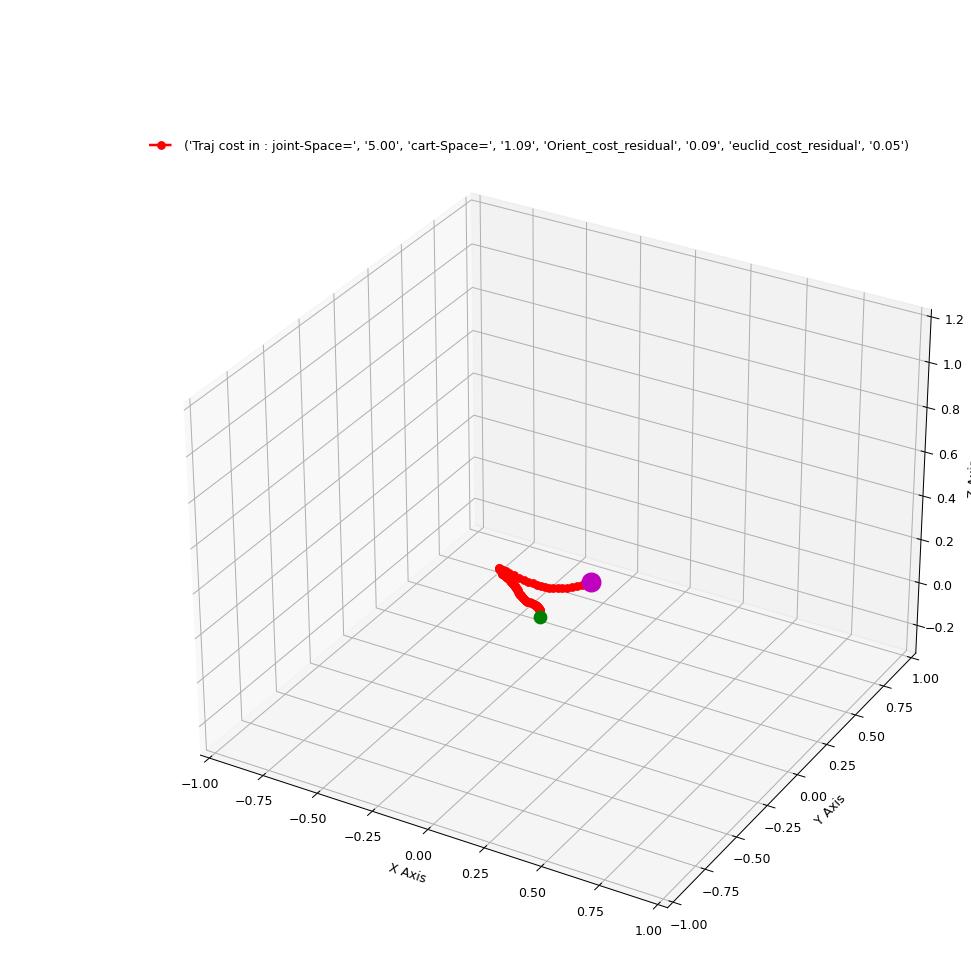

/srv/conda/envs/notebook/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<IPython.core.display.Javascript object>


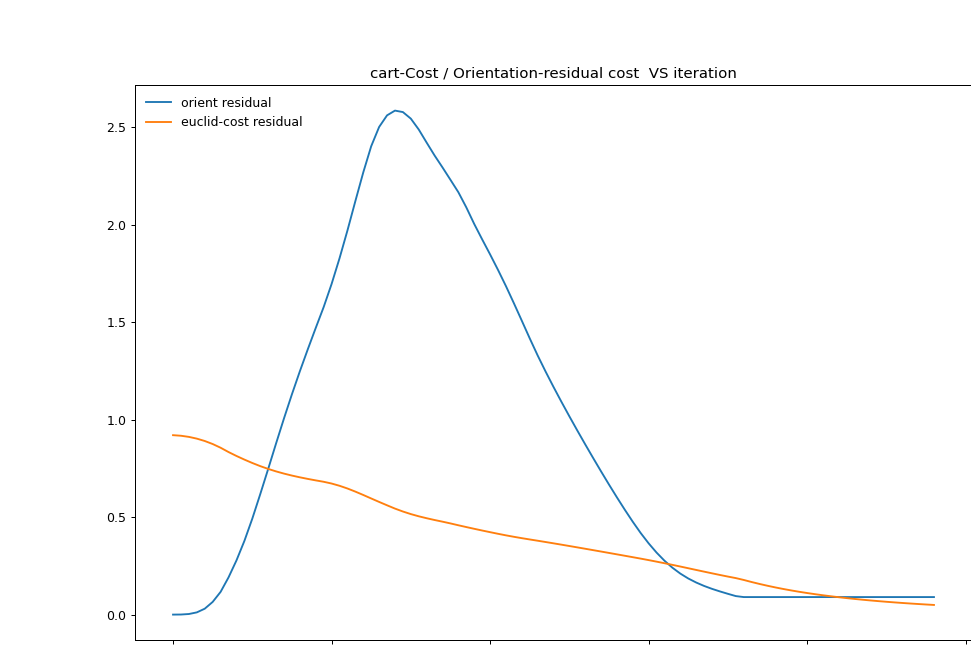

<IPython.core.display.Javascript object>


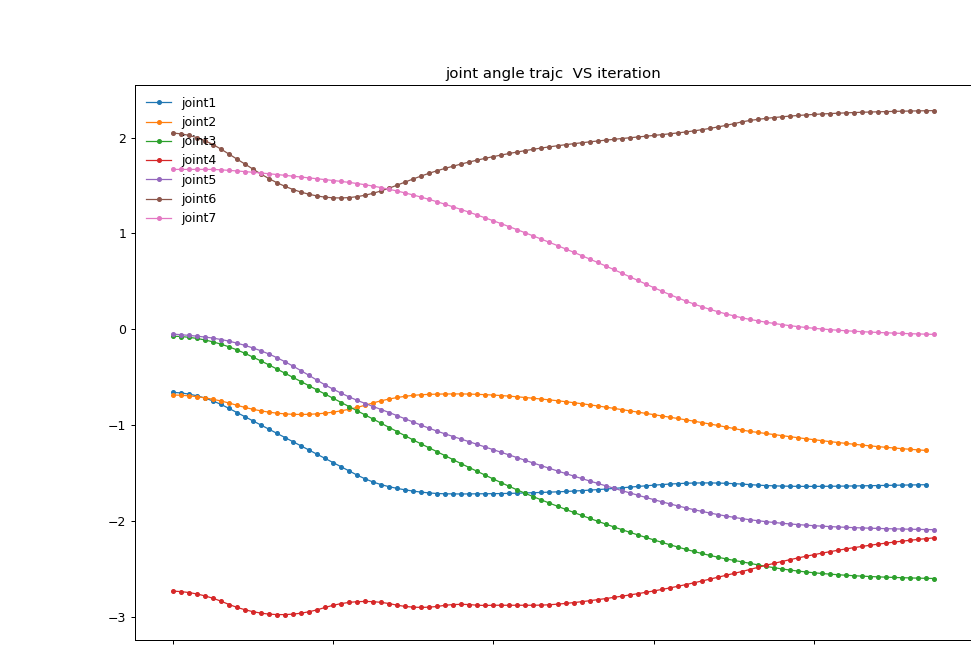

<IPython.core.display.Javascript object>


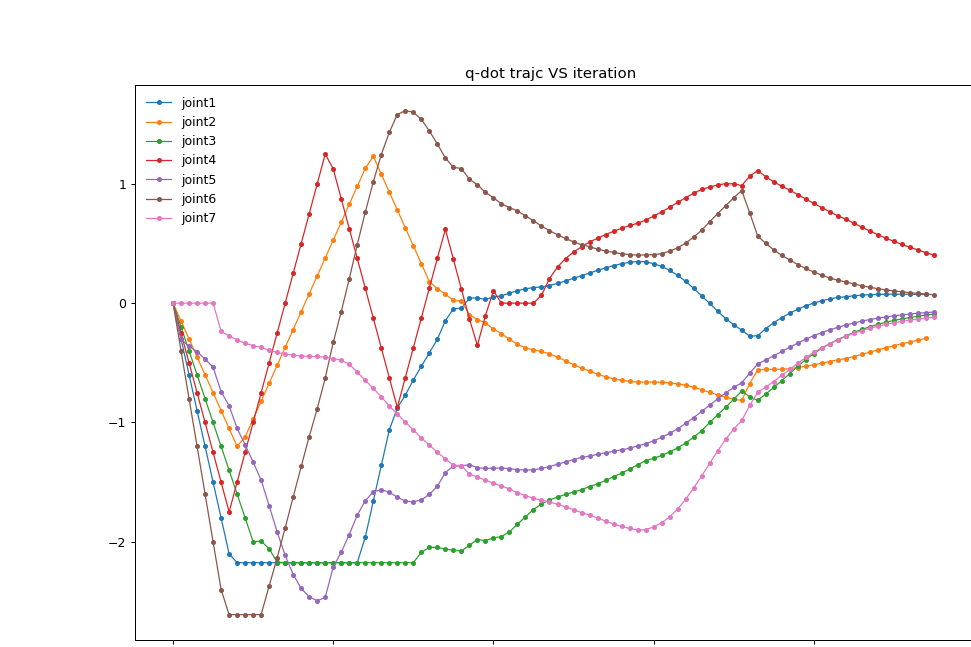

In [19]:
plotno =1
plot(orientResidual_tracker, cart_cost_tracker , trajectory,init_joint, end_cart,qdottrajc,plotno)

<IPython.core.display.Javascript object>


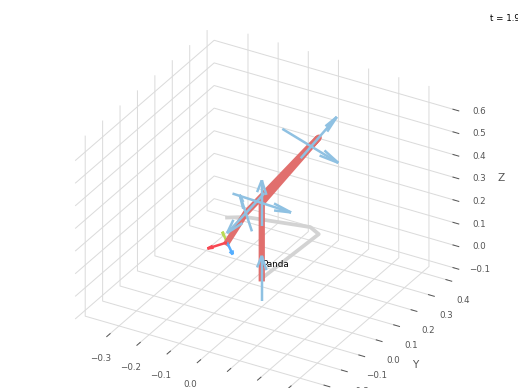

PyPlot3D backend, t = 1.9200000000000013, scene:
  Panda

In [20]:
import roboticstoolbox as rtb
trajc = np.reshape(trajectory , ( len(trajectory) ,7))
robot = rtb.models.DH.Panda()
robot.plot(trajc, dt = 0.02 , movie = 'example.gif') #for smooth visualization click an play  on  the  saved gif file in current dir (might need to refresh the directory)